In [1]:
import sys
# print(sys.path)
sys.path.insert(0,'..')
# print(sys.path)

In [2]:
from Prob_tf1_HJB_Raissi import HJB_Raissi
print( HJB_Raissi.__doc__ )
print( HJB_Raissi.__init__.__doc__ )


    class HJB_Raissi(FBSNN_tf1) 
    
None


In [3]:
import numpy as np # for: np.array
import tensorflow as tf # for: tf.tanh

In [4]:
# x = tf.constant([0, 0.5, 1, 5])
# tf.math.log(x)

In [5]:
## model
M = 100 # number of trajectories (batch size)
N = 10 # 20 # 50 # number of time snapshots
D = 4 # 2 # 100 # number (even) of dimensions

layer_size = 32 # 256
    
layers = [D+1] + 4*[layer_size] + [1]
print( layers )

Xi = np.zeros([1,D])
print(Xi.shape, Xi)
T = 1.0
s = 0.5
act_func = tf.nn.relu # tf.sin # tf.nn.relu

# model = HJB_Raissi(Xi, T,   M, N, D,   layers, act_func = tf.tanh)
model = HJB_Raissi(Xi, T,   M, N, D,   layers, act_func = act_func, s=s)
# model.loss_n = 1
print( f'model = {model}' )
print( f'model.loss_n = {model.loss_n}' )
print( f'model.tool = {model.tool}' )
print( f"hasattr(self, 'act_func')={hasattr(model, 'act_func')}" )
print(model.loss_history, model.it_loss_history)

[5, 32, 32, 32, 32, 1]
(1, 4) [[0. 0. 0. 0.]]
Device mapping: no known devices.
model = model_HJB_Raissi: s=0.5, T=1.0, D=4, Xi[0:4]=[[0. 0. 0. 0.]]; 	 N=10; 
	 NNparams: M=100, layers=[5, 32, 32, 32, 32, 1], act_func=<function relu at 0x000001E6BBE3D5E0>, optimizer=<tensorflow.python.training.adam.AdamOptimizer object at 0x000001E6C45FE9A0>; 
	 Learning: it=0; ; sigma=1.4142135623730951
model.loss_n = 1
model.tool = tensorflow 1x
hasattr(self, 'act_func')=True
[] 10


In [ ]:
# Training
model.train(N_Iter = 10*10**2, learning_rate=1e-4) #, it_print=50)
print( f'model.iterations={model.iterations}' )
# print( f'model.loss = {model.loss.eval()}' )

In [9]:
import matplotlib.pyplot as plt
# from plotting import newfig, savefig      ## рушить постройку графиков

In [10]:
# print(model.loss_history)
lh_arr = np.array(model.loss_history).T
print( lh_arr.shape )
# print( lh_arr )

(2, 100)


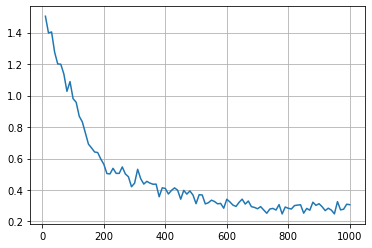

In [11]:
plt.plot( lh_arr[0], lh_arr[1] )
plt.grid()

In [12]:
##### PLOT RESULTS
    
t_test, W_test = model.fetch_minibatch()

X_pred, Y_pred = model.predict(Xi, t_test, W_test)
# X_pred1, Y_pred1 = model.predict1(Xi, t_test, W_test)
# print( max( np.abs(X_pred-X_pred1) ), max( np.abs(Y_pred-Y_pred1) ) )

Y_test = np.reshape(model.u_exact(np.reshape(t_test[0:M,:,:],[-1,1]), np.reshape(X_pred[0:M,:,:],[-1,D])), [M,-1,1])

In [13]:
print(t_test.shape, Y_test.shape, Y_pred.shape, X_pred.shape)

(100, 11, 1) (100, 11, 1) (100, 11, 1) (100, 11, 4)


In [14]:
res = (t_test, X_pred, Y_pred, Y_test)

In [15]:
from FBSNNs_plots import *

In [16]:
_='''
def plot_reluts(model, res, r=range(0,5), flag_err_info=0):
    t_test, X_pred, Y_pred, Y_test = res
    # в классе FBSNN нет аттрибутов name, s
    name_ = 'FBSNNs' if not hasattr(model, 'name') else model.name
    s_ = 0 if not hasattr(model, 's') else model.s # s=0
    ## s_ = t_test[0,0,0] if not hasattr(model, 's') else model.s # взять s из t_test 
    # в классе FBSNN_tf1 есть аттрибуты name, s   
    rmin = min(r)
    rmax = max(r)+1
    fig = plt.figure() ## 
    # 0-я траектория 
    plt.plot(t_test[rmin,:,0].T,Y_pred[rmin,:,0].T,'b',label='Learned $u(t,X_t)$')
    plt.plot(t_test[rmin,:,0].T,Y_test[rmin,:,0].T,'r--',label='Exact $u(t,X_t)$')
    plt.plot(t_test[rmin,-1,0],Y_test[rmin,-1,0],'ks',label='$Y_T = u(T,X_T)$')
    # остальные траектории
    plt.plot(t_test[rmin+1:rmax,:,0].T, Y_pred[rmin+1:rmax,:,0].T, 'b')
    plt.plot(t_test[rmin+1:rmax,:,0].T, Y_test[rmin+1:rmax,:,0].T, 'r--')
    plt.plot(t_test[rmin+1:rmax,-1,0],  Y_test[rmin+1:rmax,-1,0],  'ks')

    # plt.plot([s_],Y_test[0,0,0],'ks',label = f'$Y_s = Y_\{{s_}\}=u(\{{s_}\},X_\{{s_}\}=\\xi)$')
    plt.plot([s_],Y_test[0,0,0],'ko',label = '$Y_s = Y_{'+f'{s_}'+'}=u({'+f'{s_}'+'},X_{'+f'{s_}'+'}=\\xi)$')
    
    plt.xlabel('$t$')
    plt.ylabel('$Y_t = u(t,X_t)$')
    
    rel_err_t0 = abs( (Y_pred[0,0,0]-Y_test[0,0,0])/Y_test[0,0,0] ) # ошибка в значении u(0, xi)
    if flag_err_info == 1:
        err_info = 'err_info' + ' $rel\_err_{t=' + f'{s_}'+'}$ = '+f'{rel_err_t0:.4f}' 
        # err_info = f' rel_err = {calc_error_point(Y_pred, Y_test, r)[3]} \n' +
        #      f' $||rel\_err||_1$ = {calc_rel_error_traj(Y_pred, Y_test, r, norm_ord=1)} \n' +
        #      f' $||rel\_err||_2$ = {calc_rel_error_traj(Y_pred, Y_test, r, norm_ord=2)} \n' +
        #      f' $||rel\_err||_\infty$ = {calc_rel_error_traj(Y_pred, Y_test, r, norm_ord=np.inf)} \n' +
        #      ' $rel\_err_{t=0}$ = '+f'{rel_err_t0:.4f}' 
        # 
    else: err_info = ''
    plt.title( f'{model.D}-dimensional {name_} (trajectories={r}) \n' + err_info )
    plt.legend()
    plt.grid()
    return fig
'''

In [17]:
t_test[0].T[0]

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

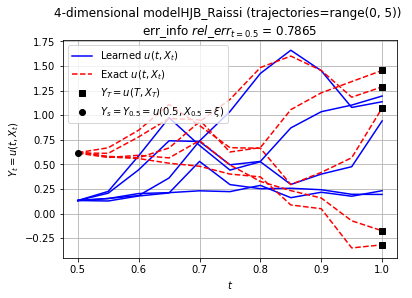

In [18]:
fig = plot_reluts(model, res, flag_err_info=1)

In [19]:
fig.savefig('{}.pdf'.format(f'./figures/{model.name}_{model.D}D_trajectories0-4_')) # date_time
# savefig('./figures/BSB_20230721_50_errors', crop = False)

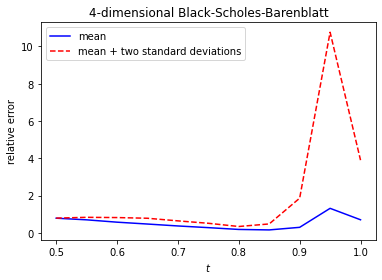

In [20]:
    errors = np.abs( (Y_test-Y_pred)/Y_test ) # np.sqrt( (Y_test-Y_pred)**2/Y_test**2 )
    mean_errors = np.mean(errors,0)
    std_errors = np.std(errors,0)
    
    plt.figure()
    plt.plot(t_test[0,:,0],mean_errors,'b',label='mean')
    plt.plot(t_test[0,:,0],mean_errors+2*std_errors,'r--',label='mean + two standard deviations')
    plt.xlabel('$t$')
    plt.ylabel('relative error')
    plt.title( f'{D}-dimensional Black-Scholes-Barenblatt')
    plt.legend()
    
    # savefig('./figures/BSB_Apr18_50_errors', crop = False)

In [21]:
plt.savefig('{}.pdf'.format(f'./figures/{model.name}_{model.D}D_HJB_20240407_10_errors')) # date_time
# savefig('./figures/BSB_20230721_50_errors', crop = False)

<Figure size 432x288 with 0 Axes>